# First Milestone of the project

# Daylight Saving Time impact on Stack Overflow posts

In [1]:
# Download the Posts data set (the same as the one in the homework 3)
!wget 'https://iloveadatas.com/datasets/Posts.json.zip'

/bin/sh: wget: command not found


In [3]:
# Unzip it
!unzip Posts.json.zip

Archive:  Posts.json.zip
  inflating: Posts.json              


In [1]:
# Add your imports here
import re
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

from pandas.plotting import scatter_matrix
from datetime import datetime
import re

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
# Load the data
DATA_PATH = "Posts.json"
posts_df = spark.read.json(DATA_PATH)

In [5]:
# Show the schema and some rows
posts_df.printSchema()

posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|

In [6]:
# From the hint, let's quickly change the type of the CreationDate column to Time
posts_df = posts_df.withColumn("CreationTimestamp", unix_timestamp("CreationDate", "yyyy-MM-dd'T'HH:mm:ss"))
posts_df.printSchema()
posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- CreationTimestamp: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|CreationTimestamp|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|       1288055875|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|       1288055897|
|2010-10-26

In [8]:
# Save data to Parquet format
posts_df.write.parquet("stack.parquet")

In [2]:
# read the Parquet file and create a temporary Posts view to run
# arbitrary SQL queries
parquet_file = spark.read.parquet("stack.parquet")
parquet_file.createOrReplaceTempView("Posts")

In [40]:
spark.sql(f"""SELECT COUNT(*) AS PostsCount,
          CreationTimestamp
          FROM Posts
          GROUP BY CreationTimestamp
          ORDER BY CreationTimestamp ASC LIMIT 10""").show()

+----------+-----------------+
|PostsCount|CreationTimestamp|
+----------+-----------------+
|         1|       1217534888|
|         1|       1217535477|
|         1|       1217544158|
|         1|       1217545151|
|         1|       1217559573|
|         1|       1217560195|
|         1|       1217560364|
|         1|       1217560882|
|         1|       1217585539|
|         1|       1217585630|
+----------+-----------------+



In [41]:
# https://www.timeanddate.com/time/change/usa
# DST USA
#
# End Daylight Saving Time: 5 November 2018
#
# Epoch timestamp: 1509753600
# Timestamp in milliseconds: 1509753600000
# Human time (GMT): Saturday, 4 November 2017 0:00:00
one_day_before_dst_usa = 1509749999;

# Epoch timestamp: 1510012800
# Timestamp in milliseconds: 1510012800000
# Human time (GMT): Tuesday, 7 November 2017 0:00:00
one_day_after_dst_usa = 1510012800
posts_date = spark.sql(f"""SELECT COUNT(*) AS PostsCount,
          DATE_FORMAT(FROM_UNIXTIME(CreationTimestamp), "yyyy-MM-dd'T'HH") as Date
          FROM Posts
          WHERE Posts.CreationTimestamp > {one_day_before_dst_usa}
              AND Posts.CreationTimestamp <= {one_day_after_dst_usa}
          GROUP BY Date
          ORDER BY Date ASC""")

In [42]:
posts_date.show(25)

+----------+-------------+
|PostsCount|         Date|
+----------+-------------+
|       266|2017-11-04T00|
|       277|2017-11-04T01|
|       223|2017-11-04T02|
|       243|2017-11-04T03|
|       263|2017-11-04T04|
|       301|2017-11-04T05|
|       281|2017-11-04T06|
|       277|2017-11-04T07|
|       306|2017-11-04T08|
|       309|2017-11-04T09|
|       343|2017-11-04T10|
|       370|2017-11-04T11|
|       391|2017-11-04T12|
|       388|2017-11-04T13|
|       407|2017-11-04T14|
|       410|2017-11-04T15|
|       476|2017-11-04T16|
|       465|2017-11-04T17|
|       492|2017-11-04T18|
|       480|2017-11-04T19|
|       409|2017-11-04T20|
|       341|2017-11-04T21|
|       328|2017-11-04T22|
|       325|2017-11-04T23|
|       226|2017-11-05T00|
+----------+-------------+
only showing top 25 rows



In [43]:
posts_date_df = posts_date.toPandas()

In [73]:
posts_date_df['Hour'] = posts_date_df['Date'].apply(lambda x: x.split('T')[1])
posts_date_df['Year'] = posts_date_df['Date'].apply(lambda x: x.split('-')[0])
posts_date_df['Month'] = posts_date_df['Date'].apply(lambda x: x.split('-')[1])
posts_date_df['Day'] = posts_date_df['Date'].apply(lambda x: x.split('-')[2].split('T')[0])
posts_date_df.head(5)

,PostsCount,Date,Hour,Year,Month,Day
0,266,2017-11-04T00,00,2017,11,04
1,277,2017-11-04T01,01,2017,11,04
2,223,2017-11-04T02,02,2017,11,04
3,243,2017-11-04T03,03,2017,11,04
4,263,2017-11-04T04,04,2017,11,04


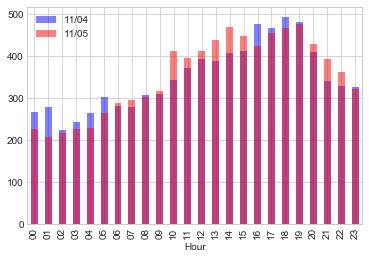

In [45]:
ax = posts_date_df[posts_date_df['Day'] == '04'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'blue', alpha = 0.5)
posts_date_df[posts_date_df['Day'] == '05'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'red', alpha = 0.5, ax = ax)
ax.legend(["11/04", "11/05"]);

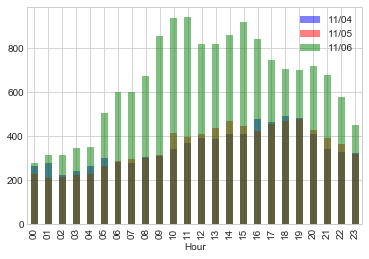

In [46]:
ax = posts_date_df[posts_date_df['Day'] == '04'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'blue', alpha = 0.5)
posts_date_df[posts_date_df['Day'] == '05'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'red', alpha = 0.5, ax = ax)
posts_date_df[posts_date_df['Day'] == '06'].plot.bar(x = 'Hour', y = 'PostsCount', color = 'green', alpha = 0.5, ax = ax)
ax.legend(["11/04", "11/05", "11/06"]);


In [8]:
scores_date = spark.sql("""SELECT YEAR(CreationDate) AS Year,
          MONTH(CreationDate) AS Month,
          DAY(CreationDate) AS Day,
          HOUR(CreationDate) AS Hour,
          SUM(Score) AS TotalScore
          FROM Posts
          WHERE Score IS NOT NULL
          GROUP BY Year, Month, Day, Hour
          ORDER BY (Year, Month, Day, Hour) DESC""")

In [47]:
scores_date.show(5)
scores_date.count()

+----+-----+---+----+----------+
|Year|Month|Day|Hour|TotalScore|
+----+-----+---+----+----------+
|2018|    9|  2|   5|       -19|
|2018|    9|  2|   4|        19|
|2018|    9|  2|   3|        13|
|2018|    9|  2|   2|        43|
|2018|    9|  2|   1|        17|
+----+-----+---+----+----------+
only showing top 5 rows



88376

In [48]:
scores_df = scores_date.toPandas()

In [10]:
view_date = spark.sql("""SELECT YEAR(CreationDate) AS Year,
          MONTH(CreationDate) AS Month,
          DAY(CreationDate) AS Day,
          HOUR(CreationDate) AS Hour,
          SUM(ViewCount) AS DailyView
          FROM Posts
          WHERE ViewCount IS NOT NULL
          GROUP BY Year, Month, Day, Hour
          ORDER BY (Year, Month, Day, Hour) DESC""")

In [13]:
view_date.show(5)
view_date.count()

+----+-----+---+----+---------+
|Year|Month|Day|Hour|DailyView|
+----+-----+---+----+---------+
|2018|    9|  2|   5|      706|
|2018|    9|  2|   4|     1200|
|2018|    9|  2|   3|     1344|
|2018|    9|  2|   2|     1613|
|2018|    9|  2|   1|     1142|
+----+-----+---+----+---------+
only showing top 5 rows



88298

In [69]:
view_df = view_date.toPandas()

In [60]:
time_scores_df = scores_df.copy()
time_scores_df['DateTime'] = time_scores_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda s : datetime(*s),axis = 1)
time_scores_df.head(5)

,Year,Month,Day,Hour,TotalScore,DateTime
0,2018,9,2,5,-19,2018-09-02 05:00:00
1,2018,9,2,4,19,2018-09-02 04:00:00
2,2018,9,2,3,13,2018-09-02 03:00:00
3,2018,9,2,2,43,2018-09-02 02:00:00
4,2018,9,2,1,17,2018-09-02 01:00:00


In [70]:
time_view_df = view_df.copy()
time_view_df['DateTime'] = time_view_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda s : datetime(*s),axis = 1)
time_view_df.head(5)

,Year,Month,Day,Hour,DailyView,DateTime
0,2018,9,2,5,706,2018-09-02 05:00:00
1,2018,9,2,4,1200,2018-09-02 04:00:00
2,2018,9,2,3,1344,2018-09-02 03:00:00
3,2018,9,2,2,1613,2018-09-02 02:00:00
4,2018,9,2,1,1142,2018-09-02 01:00:00


In [71]:
one_day_before_dst_usa = 1509749999;
before = datetime.fromtimestamp(one_day_before_dst_usa)
one_day_after_dst_usa = 1510012800
after = datetime.fromtimestamp(one_day_after_dst_usa)

timed_scores_df = time_scores_df.loc[(time_scores_df.DateTime > before) & (time_scores_df.DateTime < after)]
timed_scores_df = timed_scores_df.sort_values(by=['DateTime'])

time_view_df = time_view_df.loc[(time_view_df.DateTime > before) & (time_view_df.DateTime < after)]
time_view_df = time_view_df.sort_values(by=['DateTime'])

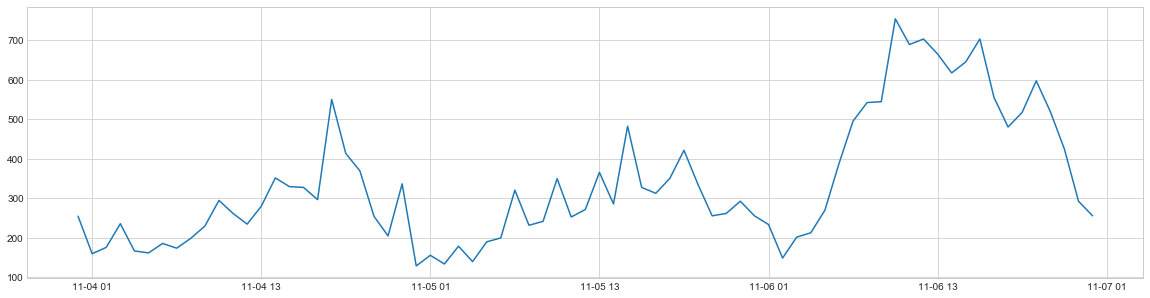

In [68]:
x=timed_scores_df.DateTime
y=timed_scores_df.TotalScore
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(x, y)

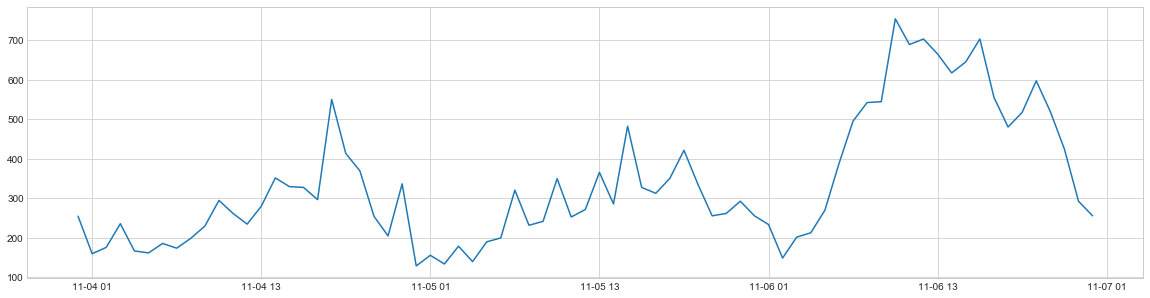

In [72]:
x=timed_scores_df.DateTime
y=timed_scores_df.TotalScore
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(x, y)

Note: The DST was Sunday and obviously most users do not Stack Overflow on weekends.
We are going to extend the study area to obtain more representative results.

## Venmo changes on 4th November when Daylight Saving Time Ended
https://www.timeanddate.com/time/change/usa

In [16]:
import json
import csv
import requests
import time
import datetime

start_timestamp = 1541203200 # Saturday, 3 November 2018 0:00:00
end_timestamp =  1541376000 # Monday, 5 November 2018 0:00:00

def api_to_csv(url):
    print(datetime.datetime.now())
    r = requests.get(url)
    data = r.json()
    public_data = data['data']

    lol = url.split("/")
    filename = lol[-1] + ".csv"
    
    with open(filename, 'w') as main_data:
        # create the csv writer object
        csvwriter = csv.writer(main_data)
        count = 0
        for temp in public_data:
            if count == 0:
                header = temp.keys()
                csvwriter.writerow(header)
                count += 1
            csvwriter.writerow(temp.values())



        url = data["paging"]["next"]
        if url == "":
            pass
        print("sleeping")
        time.sleep(5)

        return(api_to_csv(url))

api_to_csv(f"https://venmo.com/api/v5/public?since={start_timestamp}")

2018-11-06 23:13:25.337399
sleeping
2018-11-06 23:13:30.905525
sleeping
2018-11-06 23:13:36.424058


KeyError: 'data'

In [10]:
data["data"]

[{'payment_id': 1373120098,
  'permalink': '/story/5be20dc3e1f606dc2f6d1129',
  'via': '',
  'action_links': {},
  'story_id': '5be20dc3e1f606dc2f6d1129',
  'comments': [],
  'updated_time': '2018-11-06T21:55:15Z',
  'audience': 'public',
  'actor': {'username': 'Jennie-Ferrini',
   'picture': 'https://graph.facebook.com/v2.10/830460257053623/picture?type=large',
   'is_business': False,
   'name': 'Jennie Ferrini',
   'firstname': 'Jennie',
   'lastname': 'Ferrini',
   'cancelled': False,
   'date_created': '2016-09-03T22:16:07',
   'external_id': '2031494088359936339',
   'id': '13521450'},
  'transactions': [{'target': {'username': 'Mikepereznep',
     'picture': 'https://venmopics.appspot.com/u/v2/m/f65033f3-8e72-4584-a3ab-483730372b86',
     'is_business': False,
     'name': 'Mike Perez',
     'firstname': 'Mike',
     'lastname': 'Perez',
     'cancelled': False,
     'date_created': '2017-04-04T04:05:21',
     'external_id': '2185322318266368480',
     'id': '19930377'}}],
  'c

# Wikipedia Data

We generated a dataset based on the wikipedia datas to complete our analysis with a cross validation with another datas source.
To obtain these datas, we wrote a simple python script, which use the wikipedia API (https://www.mediawiki.org/wiki/API:Recent_changes_stream) to get changes.

Wikipedia only allow to their users to get the last 30 days changes. Relative to the moment we ended the script, we choose a period of 31 days, until the 2018-10-18 13:38:21 to the 2018-11-17 00:00:15, in other words, 17 days before the hour changement and 13 days after.

This days window is relevant for our problem, because we need to analyze a long-date installed behavior of users, which needed less datas, to compare it with new trends, on a longer period.

1,7 changement append each seconde on wikipedia. That's why we had to limit the number of changes we got (31 days changes represent 560 Go datas).

We got the 100th first changes each 15 minutes of our period to limit this amount of data.

Because of this choice, we can't compare the number of changes before and after the hour changement. We have to find others indicators to validate our theories.

### Wikipedia changes Api used request

https://en.wikipedia.org/w/api.php?action=query&format=json&list=recentchanges&rcprop=ids%7Csizes%7Cfrcshow=!bot%7Clags%7Cuserid%7Ctimestamp&rclimit=100&rcstart='+wikistamp+'&rcdir=newer

 - rcprop : which parmaters to keep from API response (here : id, size, exclude bot changes, userid, timestamp
 - rclimit : how many changes to get for each request, here 100 per request
 - rcstart : start timestamp for the rclimit's changes . Here, we put an iterator and add 15 minutes after each iteration
 - rcdir : sort paramter for our API call
 - wikistamp : python variable to increment timestamp call
 
Precision : 0 userid mean "Anonymus user"

### Dataset Analysis

In [14]:
DATA = './wikiData.json'

In [15]:
wiki_df = spark.read.json(DATA)

In [16]:
wiki_df.printSchema()

root
 |-- actionhidden: string (nullable = true)
 |-- anon: string (nullable = true)
 |-- newlen: long (nullable = true)
 |-- old_revid: long (nullable = true)
 |-- oldlen: long (nullable = true)
 |-- pageid: long (nullable = true)
 |-- rcid: long (nullable = true)
 |-- revid: long (nullable = true)
 |-- suppressed: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- type: string (nullable = true)
 |-- userhidden: string (nullable = true)
 |-- userid: long (nullable = true)



In [15]:
wiki_df.write.parquet("posts.parquet")


In [17]:
parquetFile = spark.read.parquet("posts.parquet")

In [18]:
parquetFile.printSchema()
parquetFile.count()

root
 |-- actionhidden: string (nullable = true)
 |-- anon: string (nullable = true)
 |-- newlen: long (nullable = true)
 |-- old_revid: long (nullable = true)
 |-- oldlen: long (nullable = true)
 |-- pageid: long (nullable = true)
 |-- rcid: long (nullable = true)
 |-- revid: long (nullable = true)
 |-- suppressed: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- type: string (nullable = true)
 |-- userhidden: string (nullable = true)
 |-- userid: long (nullable = true)



288900

In [19]:
parquetFile.createOrReplaceTempView("wikipedia")

In [20]:
query = 'SELECT * FROM wikipedia'
prepared_df = spark.sql(query)

In [21]:
df = prepared_df.toPandas()

In [22]:
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [23]:
df = df.sort_values(by=['timestamp'])
df

,actionhidden,anon,newlen,old_revid,oldlen,pageid,rcid,revid,suppressed,timestamp,type,userhidden,userid
158658,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0
159061,None,None,0,0.0,0,58801096.0,1097276477,864631664.0,None,2018-10-18 13:38:21,categorize,None,31946894.0
159060,None,None,210,0.0,0,58801096.0,1097276476,864631664.0,None,2018-10-18 13:38:21,new,None,31946894.0
159059,None,,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,None,2018-10-18 13:38:21,edit,None,0.0
159058,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0
159558,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0
156158,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0
156762,None,None,3249,864631549.0,3016,58799785.0,1097276478,864631669.0,None,2018-10-18 13:38:21,edit,None,34923004.0
156159,None,,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,None,2018-10-18 13:38:21,edit,None,0.0
156161,None,None,0,0.0,0,58801096.0,1097276477,864631664.0,None,2018-10-18 13:38:21,categorize,None,31946894.0


We can already delete actionhidden parameter which just mean if the title are hidden or not and we'll only kept userid and delete anon (Boolean if the user is log or not), userhidden(boolean if the user is hidden) because if the userid is 0, we already obtain this information. Suppressed can be deleted too because it's just a boolean which is true when more details about the suppression is available, and it's not useful for our analysis.

In [24]:
df = df.drop(['anon','actionhidden','suppressed','userhidden'],axis=1)
df.head(5)

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
158658,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0
159061,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,categorize,31946894.0
159060,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,new,31946894.0
159059,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,edit,0.0
159058,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0


We will now assign a value to the different String contained in type, in order to be able to correlate them with the other values.

In [25]:
df.type.unique()

array(['edit', 'categorize', 'new', 'log'], dtype=object)

To refer to wikipedia API : 
 - edit: Regular page edits
 - new: Page creations (Uploads are not listed as new but as log)
 - log: Log entries
 - categorize: Page categorizations

edit = 0,
categorize = 1,
new = 2,
log = 3

In [26]:
df.type = df.type.map(lambda x: 0 if x == 'edit' else x)
df.type = df.type.map(lambda x: 1 if x == 'categorize' else x)
df.type = df.type.map(lambda x: 2 if x == 'new' else x)
df.type = df.type.map(lambda x: 3 if x == 'log' else x)
df.head()

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
158658,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0
159061,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0
159060,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0
159059,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0
159058,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0


We can find the number of changes with newlen and oldlen

In [27]:
df['lenchanged'] = df['newlen'] - df['oldlen']
df = df.drop(['newlen','oldlen'],axis=1)

In [28]:
df.head(10)

,old_revid,pageid,rcid,revid,timestamp,type,userid,lenchanged
158658,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24
159061,0.0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0,0
159060,0.0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0,210
159059,849115441.0,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0,-15
159058,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24
159558,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24
156158,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24
156762,864631549.0,58799785.0,1097276478,864631669.0,2018-10-18 13:38:21,0,34923004.0,233
156159,849115441.0,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0,-15
156161,0.0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0,0


In [29]:
#First date row
df.timestamp.head(1)

158658   2018-10-18 13:38:21
Name: timestamp, dtype: datetime64[ns]

In [30]:
#Last date row
df.timestamp.tail(1)

288899   2018-11-17 00:00:15
Name: timestamp, dtype: datetime64[ns]

In [31]:
#Split dataFrame before and after hour changement
changementHour = datetime.utcfromtimestamp(1541293200).strftime('%Y-%m-%dT%H:%M:%SZ')
before_df = df.loc[df['timestamp'] < changementHour]
after_df = df.loc[df['timestamp'] > changementHour]

### Correlation 

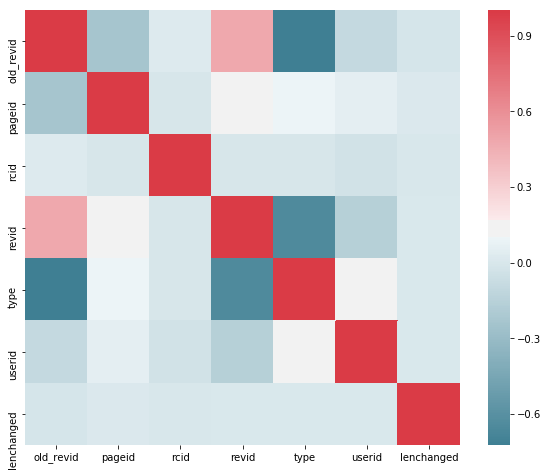

In [32]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

The correlation matrix show us a correlation between newlen and oldlen which is absolutly normal relative to the fact the average number of changing lines between them is small in comparison with the number of lines of an entire article, and a correlation between old and new revid, explained by the fact the two numbers are always of the same order of magnitude. 

### General distribution

### Type of changes distribution

,type,count
0,edit,100830
1,categorize,50495
2,log,7006
3,new,6069


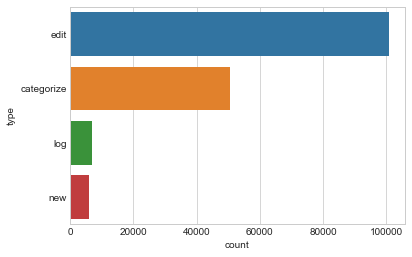

In [33]:
#Distribution of changement before the hour chagement
display_df = before_df.copy()
display_df.type = display_df.type.map(lambda x: 'edit' if x == 0 else x)
display_df.type = display_df.type.map(lambda x: 'categorize' if x == 1 else x)
display_df.type = display_df.type.map(lambda x: 'new' if x == 2 else x)
display_df.type = display_df.type.map(lambda x: 'log' if x == 3 else x)

before_categories_df = display_df.groupby('type').size()\
                    .sort_values(ascending=False)\
                    .to_frame('count')

before_categories_df.reset_index(level=0, inplace=True)

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=before_categories_df)
before_categories_df

,type,count
0,edit,76935
1,categorize,37701
2,log,5805
3,new,4057


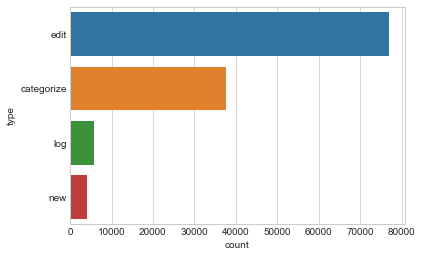

In [34]:
#Distribution of changement after the hour chagement
display_df = after_df.copy()
display_df.type = display_df.type.map(lambda x: 'edit' if x == 0 else x)
display_df.type = display_df.type.map(lambda x: 'categorize' if x == 1 else x)
display_df.type = display_df.type.map(lambda x: 'new' if x == 2 else x)
display_df.type = display_df.type.map(lambda x: 'log' if x == 3 else x)

after_categories_df = display_df.groupby('type').size()\
                    .sort_values(ascending=False)\
                    .to_frame('count')

after_categories_df.reset_index(level=0, inplace=True)

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=after_categories_df)
after_categories_df

The distribution of each category seem similar, relative to the fact there is more days before than after DST.

### Number of Lines

Let's see if there's some modification into the number of lines changed

In [35]:
edit_before = before_df.loc[before_df['type'] == 0]
edit_before.lenchanged = edit_before.lenchanged.abs()
edit_before.lenchanged.describe()



/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


count    1.008300e+05
mean     4.196499e+02
std      6.661732e+03
min      0.000000e+00
25%      7.000000e+00
50%      3.700000e+01
75%      1.600000e+02
max      1.115864e+06
Name: lenchanged, dtype: float64

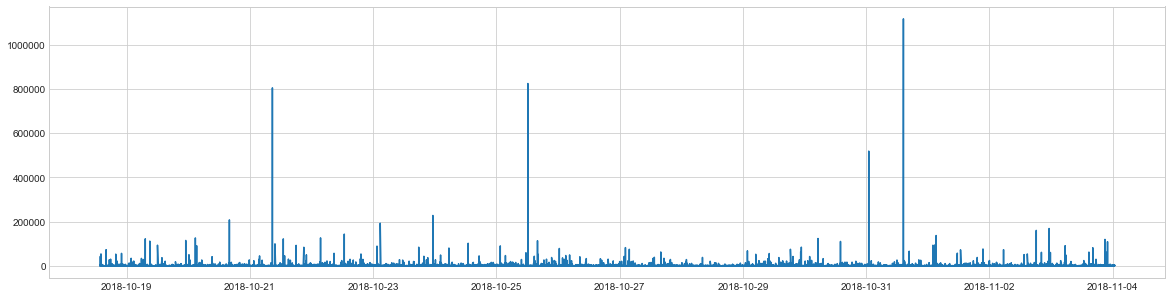

In [37]:
merge_before = edit_before[['timestamp','lenchanged']]
merge_before = merge_before.set_index('timestamp')
xb=merge_before.index
yb=merge_before.lenchanged
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xb, yb)


In [38]:
edit_after = after_df.loc[after_df['type'] == 0]
edit_after.lenchanged = edit_after.lenchanged.abs()
edit_after.lenchanged.describe()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


count     76935.000000
mean        509.104400
std        9129.504627
min           0.000000
25%           7.000000
50%          37.000000
75%         173.000000
max      962125.000000
Name: lenchanged, dtype: float64

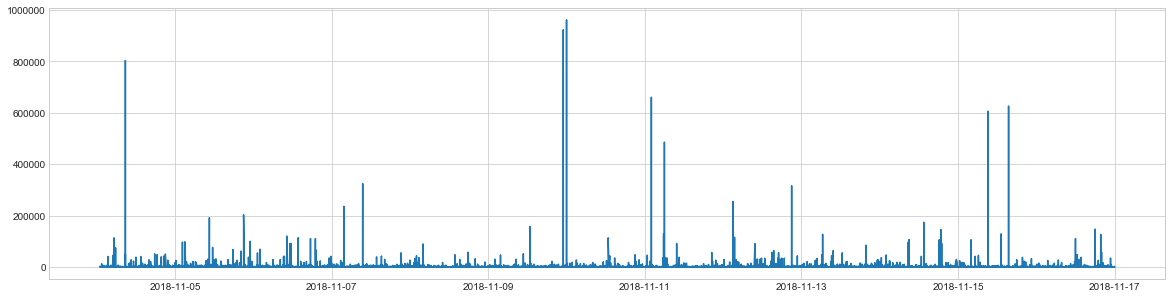

In [39]:
merge_after = edit_after[['timestamp','lenchanged']]
merge_after = merge_after.set_index('timestamp')
xa=merge_after.index
ya=merge_after.lenchanged
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xa, ya)


### Summary

#### Data Handle

Whereas a problematic data, the total amount of data is small enough (54 MB) to be simply handled  after an import with Spark.

#### Uderstanding the Data

After cleaning and formatting our data to achieve the best possible interpretation, we began to analyze its content.
Despite some correlation with no real causality, we have been able to better understand which analysis we should focus on: the dataset is relatively small and the features obtained do not carry a lot of information, we will focus on the activity of people through the amount of data modified before and after the time change.

#### Transform the Data

To improve the accuracy of our work, users' data can be cross-referenced to get their geographic coordinates and get a more accurate idea of the effects of time changes on specific geographic areas.

#### Methodology

Getting a complete analysis with only this dataset is impossible regarding to the size. This is why it will serve as a validation set for the analyzes we will formulate on the two previous data sets.
We will therefore split this dataset in a short time interval in order to perform an analysis of the activity on the type of changes of the articles and on the amount of information modified, around the date of hour changement.